# Predicting the Price of Round Cut Diamonds

## Polynomial Regression Machine Learning Algorithm

The goal of this machine learning project is to create a stable model to predict the price of round cut diamonds. Please refer to the README.md file to get more information about the dataset.

### Import packages

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Import .csv file 

In [7]:
Diamonds = pd.read_csv('Diamonds.csv')
Diamonds.head()

,price,carat,cut,color,clarity,depth,table,x,y,z
0,326,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
1,326,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
2,327,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
3,334,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
4,335,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75


In [8]:
Diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
price      53940 non-null int64
carat      53940 non-null float64
cut        53940 non-null object
color      53940 non-null object
clarity    53940 non-null object
depth      53940 non-null float64
table      53940 non-null float64
x          53940 non-null float64
y          53940 non-null float64
z          53940 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [9]:
Diamonds.isnull().sum()

price      0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
dtype: int64

_The dataset has 53,940 round cut diamonds. There are no null values._

### Correlation

A correlation matrix provides us the linear relationships between each pair of numerical variables in the dataframe. The Pearson coefficient indicates the strength of the linear relationship.

In [10]:
matrix = np.triu(Diamonds.corr(), 1) # used for a mask to eliminate the duplicate portion of the correlation matrix

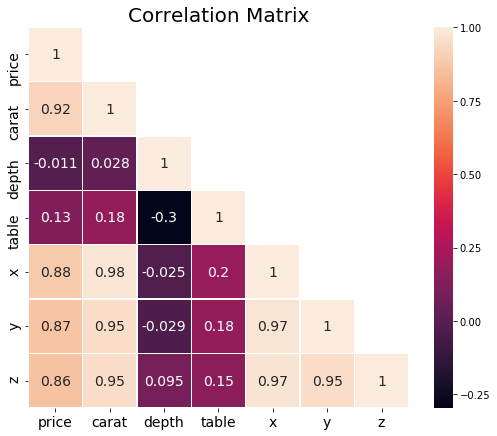

In [11]:
plt.figure(figsize = (9, 7))
sns.heatmap(Diamonds.corr(), annot = True, square = True, mask = matrix, linewidths = 0.5, annot_kws = {'size': 14})
plt.title('Correlation Matrix', fontsize = 20)
plt.tick_params(labelsize = 14)
plt.show()

_Depth and table have almost no correlation with price so they can be dropped from the model. There seems to be some multicollinearity with some of the independent variables, namely carat, x, y and z. This will be addressed also._

In [12]:
Diamonds.drop(['depth', 'table'], axis = 1, inplace = True)

### Label Encoding

_Three of the varibles are categorical. They must be encoded before they can be used in the model. Label encoding was chosen as each of the variables, cut, color and clarity, have ordinal data._

In [13]:
Diamonds.cut = Diamonds.cut.map(
                                {'Fair': 0,
                                 'Good': 1,
                                 'Very Good': 2,
                                 'Premium': 3,
                                 'Ideal': 4
                                 }
                                )

Diamonds.color = Diamonds.color.map(
                                    {'J': 0,
                                     'I': 1,
                                     'H': 2,
                                     'G': 3,
                                     'F': 4,
                                     'E': 5,
                                     'D': 6
                                     }
                                    )

Diamonds.clarity = Diamonds.clarity.map(
                                        {'I1': 0,
                                         'SI2': 1,
                                         'SI1': 2,
                                         'VS2': 3,
                                         'VS1': 4,
                                         'VVS2': 5,
                                         'VVS1': 6,
                                         'IF': 7
                                         }
                                        )

Diamonds.head()

,price,carat,cut,color,clarity,x,y,z
0,326,0.23,4,5,1,3.95,3.98,2.43
1,326,0.21,3,5,2,3.89,3.84,2.31
2,327,0.23,1,5,4,4.05,4.07,2.31
3,334,0.29,3,1,3,4.20,4.23,2.63
4,335,0.31,1,0,1,4.34,4.35,2.75


It was mentioned earlier that some multicollinearity is suspected. It can be confirmed by checking the variance inflation factor (VIF). Each independent variable is regressed against each indendent variable and the VIF is calculated.

$VIF = \frac{1}{1 - R^2}$

If the independent variable is not dependent on other independent variables, an acceptable VIF will fall between 1 and 5. A VIF greater than 10 is a clear indication that there is some collinearity between the variables.

In [14]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Regress carat against all other features
y, X = dmatrices('carat ~ cut + color + clarity + x + y + z', Diamonds, return_type = 'dataframe')

# For each X, calculate VIF and save in dataframe
VIF = pd.DataFrame()
VIF['Features'] = X.columns
VIF['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(VIF)

    Features        VIF
0  Intercept  68.027335
1        cut   1.054498
2      color   1.101755
3    clarity   1.213826
4          x  33.264335
5          y  20.268435
6          z  17.823259


Such high VIF scores confirm the suspicion! The variables x, y and z are dropped leaving only price, carat, cut, color and clarity.

In [15]:
Diamonds.drop(['x', 'y', 'z'], axis = 1, inplace = True)

In [16]:
Diamonds.describe()

,price,carat,cut,color,clarity
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,3932.799722,0.797940,2.904097,3.405803,3.051020
std,3989.439738,0.474011,1.116600,1.701105,1.647136
min,326.000000,0.200000,0.000000,0.000000,0.000000
25%,950.000000,0.400000,2.000000,2.000000,2.000000
50%,2401.000000,0.700000,3.000000,3.000000,3.000000
75%,5324.250000,1.040000,4.000000,5.000000,4.000000
max,18823.000000,5.010000,4.000000,6.000000,7.000000


### Establish in- and dependent variables

In [17]:
X = Diamonds.drop(['price'], axis = 1)
y = Diamonds.price

The dataset is randomly split into a train and test set on an 80:20 ratio. A linear regression model is applied and $R^2 = 0.90218$

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 313)

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)
print('R2: %0.5f' % lr.score(X_test, y_test))

R2: 0.90218


### Scatterplot of actual prices against predicted prices

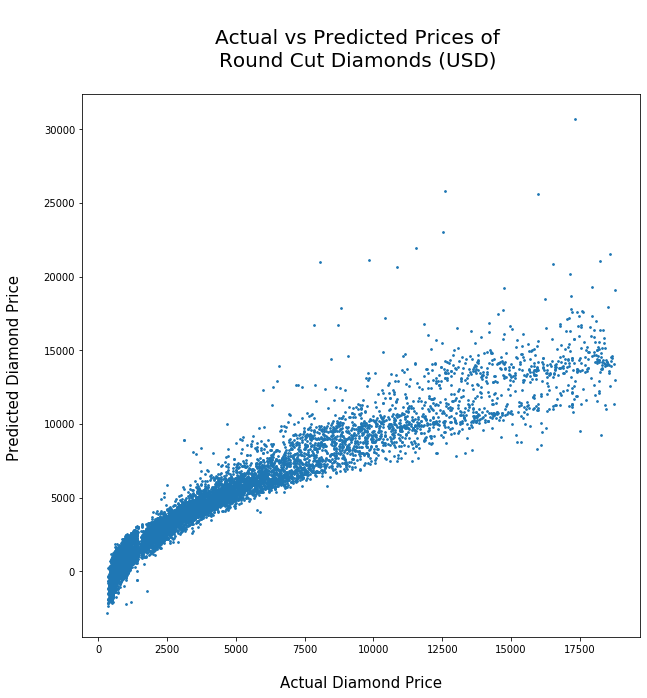

In [20]:
# Plot actual vs prediction (linear regression)
plt.figure(figsize = (10, 10))
plt.scatter(y_test, lr_y_pred, s = 3)
plt.xlabel('\nActual Diamond Price', fontsize = 15)
plt.ylabel('Predicted Diamond Price \n', fontsize = 15)
plt.title('\nActual vs Predicted Prices of \nRound Cut Diamonds (USD) \n', fontsize = 20)
plt.show()

The scatter plot reveals the relationship between the actual price against the predicted price is somewhat curvilinear. Would the model perform better if some polynomial features were introduced? 

### Determine number of degrees for polynomial regression

Iterate through the data to determine the number of degrees that will produce maximum $R^2$. This peaks at 5 degrees with a value of 0.976.

In [21]:
from sklearn.preprocessing import PolynomialFeatures

# Determine best number of polynomial degrees
R2 = []
for i in range(1, 8):
    poly_feat = PolynomialFeatures(degree = i)
    X_poly_train = pd.DataFrame(poly_feat.fit_transform(X_train))
    X_poly_test = pd.DataFrame(poly_feat.transform(X_test))
    poly_reg = LinearRegression()
    poly_reg.fit(X_poly_train, y_train)
    y_pred = poly_reg.predict(X_poly_test)
    R2.append(r2_score(y_pred, y_test))
print('Highest R2 =', round(max(R2), 3), 'and occurs when degree =', R2.index(max(R2)) + 1,'.')

Highest R2 = 0.976 and occurs when degree = 5 .


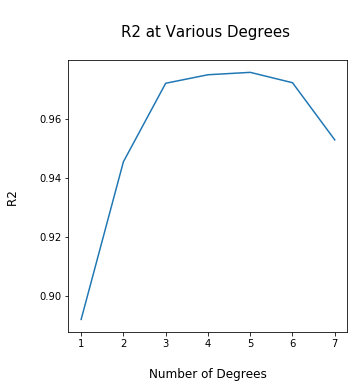

In [22]:
plt.figure(figsize=(5, 5))
plt.plot(range(1, 8), R2)
plt.xlabel('\nNumber of Degrees', fontsize = 12)
plt.ylabel('R2 \n', fontsize = 12)
plt.title('\nR2 at Various Degrees \n', fontsize = 15)
plt.show()

### Train/Test the model

The model is trained on 43,152 instances (80%) and tested on the remaining 10,788 instances (20%). A small amount of L2 penalty was applied to reduce some of the variance introduced by a high degree polynomial algorithm. K-fold cross validation with 4 folds gives a stable performance. This model will likely be able to generalize well to new data.

In [25]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

poly_feat = PolynomialFeatures(degree = 5)
X_poly_train = pd.DataFrame(poly_feat.fit_transform(X_train))
X_poly_test = pd.DataFrame(poly_feat.transform(X_test))
poly_reg = Ridge(alpha = 10)
poly_reg.fit(X_poly_train, y_train)
poly_reg_y_pred = poly_reg.predict(X_poly_test)

(print('MODEL METRICS (Train)', '\nR2: %0.5f' % poly_reg.score(X_poly_train, y_train), '\nAdj R2: %0.5f' 
       % (1 - (((len(X_poly_test.index) - 1) / (len(X_poly_test.index) - len(X_poly_test.columns) - 1)) * 
       (1 - poly_reg.score(X_poly_train, y_train)))), '\nRMSE: $%0.0f' % 
       np.sqrt(mean_squared_error(y_train, poly_reg.predict(X_poly_train))), '\n\nMODEL METRICS (Test)', 
       '\nR2: %0.5f' % poly_reg.score(X_poly_test, y_test), '\nAdj R2: %0.5f' % 
       (1 - (((len(X_poly_test.index) - 1) / (len(X_poly_test.index) - len(X_poly_test.columns) - 1)) * 
       (1 - poly_reg.score(X_poly_test, y_test)))), '\nRMSE: $%0.0f' % 
       np.sqrt(mean_squared_error(y_test, poly_reg_y_pred)), '\n\nK-FOLD CROSS VALIDATION', '\nR2: %0.5f' % 
       cross_val_score(Ridge(alpha = 10), X_poly_train, y_train, cv = 4).mean(), '(k = 4)'))


MODEL METRICS (Train) 
R2: 0.97755 
Adj R2: 0.97728 
RMSE: $597 

MODEL METRICS (Test) 
R2: 0.97719 
Adj R2: 0.97692 
RMSE: $604 

K-FOLD CROSS VALIDATION 
R2: 0.97651 (k = 4)


The $R^2$ approaches 98% with a root mean squared error of $604, approximately 15% of the mean of the target variable.

### Plot the actual prices against predicted prices

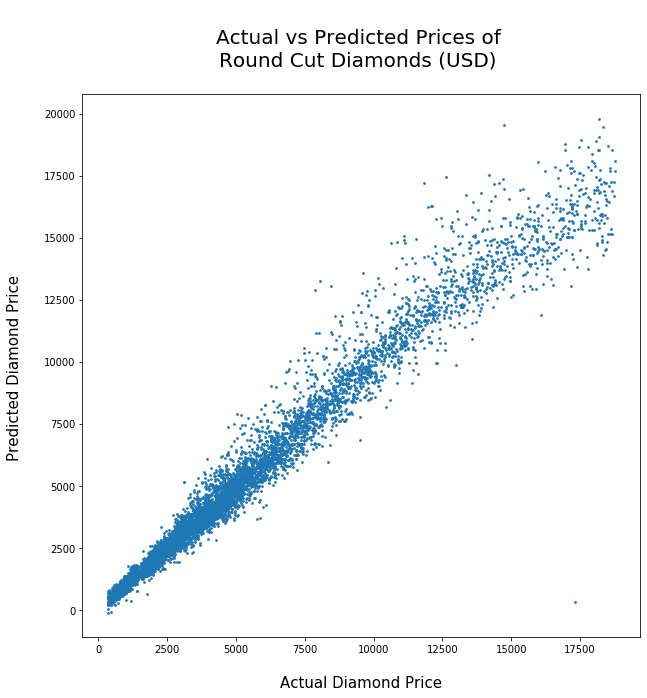

In [61]:
# Plot actual vs prediction (polynomial regression with ridge regularization)
plt.figure(figsize=(10, 10))
plt.scatter(y_test, poly_reg_y_pred, s = 3)
plt.xlabel('\nActual Diamond Price', fontsize = 15)
plt.ylabel('Predicted Diamond Price \n', fontsize = 15)
plt.title('\nActual vs Predicted Prices of \nRound Cut Diamonds (USD) \n', fontsize = 20)
plt.show()

From the new scatterplot, it is easy to see that this model has much better predictive capabilities than the original one!

#### Topics Covered:

1. Linear Regression
2. Polynomial Regression
3. Multicollinearity
4. Variance Inflation Factor